# A demo of using RDKitFF and OpenBabelFF
Demonstrate using the force field wrapper `RDKitFF` for RDKit force field and `OpenBabelFF` for Openbabel force field. Compared to the original APIs,
- ROO cannot be optimized by RDKit Force Field, but RDKitFF provides a workaround for it.
- more consistent APIs using RDKitFF and OpenBabelFF

Something needs to keep in mind:
- OpenBabelFF by default allowing interfragmental interactions, but you need to set `ignore_interfrag_interactions=False` to allow interfragmental interactions for RDKitFF.
- When dealing with constrained optimization, in using OpenBabelFF, you need to set constraint before calling `setup()` (or calling `setup()` again after setting constraints); but in RDKitFF, you can only set constraint after calling `setup()`

In [1]:
import os
import sys
# To add this RDMC into PYTHONPATH in case you doesn't do it
sys.path.append(os.path.dirname(os.path.abspath('')))

import numpy as np
import matplotlib.pyplot as plt

from rdmc import OpenBabelFF, RDKitFF, RDKitMol
from rdmc.plotter import plot_curve
from rdmc.view import grid_viewer, mol_viewer, mol_animation

%load_ext autoreload
%autoreload 2

RDKit WARNING: [23:02:58] WARNING: not removing hydrogen atom without neighbors


## 1. RDKit Force Field 

In [2]:
mol1 = RDKitMol.FromSmiles('CCCO[O]')
mol1.EmbedConformer()

Create a force field object

In [3]:
ff = RDKitFF('mmff94s')
print(ff.type)

mmff94s


Check optimizibility and make molecule optimizable

In [4]:
opt_mol = mol1.Copy()
ff.setup(opt_mol, ignore_interfrag_interactions=False)
print(f'Optimizability of this molecule: {ff.is_optimizable()}')

Optimizability of this molecule: True


Optimize a single conformer (conformer 0)

In [5]:
success = ff.optimize()
print(f'Optimization success: {success}')
opt_mol = ff.get_optimized_mol()
mol_viewer(opt_mol)

Optimization success: True


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2. Openbabel Force Field

Create a Openbabel force field object

In [6]:
obff = OpenBabelFF('mmff94s')
print(obff.type)

mmff94s


Check optimizibility and make molecule optimizable

In [7]:
opt_mol = mol1.Copy()
obff.setup(opt_mol)
print(f'Optimizability of this molecule: {obff.is_optimizable()}')

Optimizability of this molecule: True


In [8]:
obff.optimize()
opt_mol = obff.get_optimized_mol()
mol_viewer(opt_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3. Intermolecular optimization
RDKitFF and OpenBabelFF may not converge to the same orientation due to being differently parametrized

In [9]:
mol2 = RDKitMol.FromSmiles('C=O.C=O')
mol2.EmbedConformer()

print('Before optimization')
mol_viewer(mol2)

Before optimization


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

RDKitFF

In [10]:
ff = RDKitFF()
ff.setup(mol2.Copy(), ignore_interfrag_interactions=False)
ff.optimize()
mol_viewer(ff.get_optimized_mol())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

OpenBabelFF

In [11]:
ff = OpenBabelFF()
ff.setup(mol2.Copy())
ff.optimize()
mol_viewer(ff.get_optimized_mol())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 4. Constrained optimization

Set atom (1, 2) and (0, 3) = 2 Angstrom

In [12]:
xyz = """C      2.164196    0.180658    0.005381
O      0.942631    0.078687    0.002344
C     -2.138178   -0.178485   -0.005316
O     -3.360016   -0.280479   -0.008354
H      2.826486   -0.691971    0.123773
H      2.673219    1.151062   -0.110098
H     -1.518697   -0.529599   -0.845624
H     -1.589641    0.270129    0.837895"""

mol3 = RDKitMol.FromXYZ(xyz, header=False)

print('Before optimization')
print(f'd(1,2) = {mol3.GetConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {mol3.GetConformer().GetBondLength([0,3])}\n')
mol_viewer(mol3).update()

Before optimization
d(1,2) = 3.091533633597571
d(0,3) = 5.54344245067431



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
ff = RDKitFF()
ff.setup(mol3.Copy())
ff.add_distance_constraint([1,2], 2.0, force_constant=1e4)
ff.add_distance_constraint([0,3], 2.0, force_constant=1e4)
ff.optimize()
opt_mol = ff.get_optimized_mol()
print(f'd(1,2) = {opt_mol.GetConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {opt_mol.GetConformer().GetBondLength([0,3])}\n')
mol_viewer(opt_mol).render()

d(1,2) = 2.0104160746707507
d(0,3) = 2.010416257048526



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
ff = OpenBabelFF()
ff.mol = mol3.Copy()  # directly assign mol to allow correct atom index when setting constraints
ff.add_distance_constraint([1,2], 2.0)
ff.add_distance_constraint([0,3], 2.0)
ff.setup()
ff.optimize()
opt_mol = ff.get_optimized_mol()
print(f'd(1,2) = {opt_mol.GetConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {opt_mol.GetConformer().GetBondLength([0,3])}\n')
mol_viewer(opt_mol, 'sdf').render()

d(1,2) = 2.000839724527651
d(0,3) = 2.0010851916742816



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 5. Simultaneous constrained optimization for multiple conformers

Before optimization

In [15]:
xyz = """C      2.164196    0.180658    0.005381
O      0.942631    0.078687    0.002344
C     -2.138178   -0.178485   -0.005316
O     -3.360016   -0.280479   -0.008354
H      2.826486   -0.691971    0.123773
H      2.673219    1.151062   -0.110098
H     -1.518697   -0.529599   -0.845624
H     -1.589641    0.270129    0.837895"""

mol5 = RDKitMol.FromXYZ(xyz, header=False)
mol5.EmbedMultipleConfs(4)

viewer = grid_viewer(viewer_grid=(2, 2), viewer_size=(600, 400))
grids = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in range(4):
    print(f'conformer {i}')
    print(f'd(1,2) = {mol5.GetConformer(i).GetBondLength([1,2])}\n'
          f'd(0,3) = {mol5.GetConformer(i).GetBondLength([0,3])}\n')
    mol_viewer(opt_mol, viewer=viewer, viewer_loc=grids[i])


conformer 0
d(1,2) = 1.2063998108523586
d(0,3) = 1.2184912938829549

conformer 1
d(1,2) = 1.2174957149586882
d(0,3) = 1.200772130496606

conformer 2
d(1,2) = 1.215740413408354
d(0,3) = 1.2160368385583347

conformer 3
d(1,2) = 1.2325016220391336
d(0,3) = 1.1830709948398148



Optimization and constraint both d(1,2) and d(0,3) to be 2.0

In [16]:
ff = RDKitFF()
ff.setup(mol5.Copy())
ff.add_distance_constraint([1,2], 2.0, force_constant=1e3)
ff.add_distance_constraint([0,3], 2.0, force_constant=1e3)
ff.optimize_confs()
opt_mol = ff.get_optimized_mol()

viewer = grid_viewer(viewer_grid=(2, 2), viewer_size=(600, 400))
grids = [(0,0), (0,1), (1,0), (1,1)]
for i in range(4):
    print(f'conformer {i}')
    print(f'd(1,2) = {opt_mol.GetConformer(i).GetBondLength([1,2])}\n'
          f'd(0,3) = {opt_mol.GetConformer(i).GetBondLength([0,3])}\n')
    mol_viewer(opt_mol, viewer=viewer, viewer_loc=grids[i])
print(f'Force field energies for each conformers: {ff.get_conformer_energies()}')
viewer.update()

conformer 0
d(1,2) = 2.0813156053971986
d(0,3) = 2.0813153695214015

conformer 1
d(1,2) = 2.0813156435342073
d(0,3) = 2.081313941086091

conformer 2
d(1,2) = 2.0813154939008562
d(0,3) = 2.0813154862903285

conformer 3
d(1,2) = 2.0813163949439963
d(0,3) = 2.081315013481825

Force field energies for each conformers: [44.319330798428155, 44.31933084017121, 44.31933091646835, 44.31933112746298]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 6. 1D torsional scan

In [17]:
xyz="""O     -1.4560320000   -0.6564780000   -0.0547780000
C      0.6264870000    0.6420160000   -0.2996580000
C     -0.7756090000    0.5456950000    0.3029210000
C      1.5452770000   -0.5075760000    0.1202110000
H      1.0636220000    1.6047080000   -0.0081600000
H      0.5390000000    0.6678840000   -1.3943400000
H     -1.3675760000    1.4276160000    0.0200750000
H     -0.7153500000    0.5286660000    1.3946760000
H      1.7247880000   -0.4909950000    1.1997250000
H      2.5146430000   -0.4479850000   -0.3811650000
H      1.0902030000   -1.4695310000   -0.1238680000
H     -1.5780000000   -0.6493500000   -1.0095640000"""

mol6 = RDKitMol.FromXYZ(xyz, header=False)

torsion1 = mol6.GetTorsionalModes(excludeMethyl=True)[0]

In [18]:
ff = RDKitFF()
ff.setup(mol6.Copy())
angles1, rigid_E = ff.torsional_scan_1d(torsion1, num_points=45, return_xyz=False)
angles2, relax_E = ff.torsional_scan_1d(torsion1, num_points=45, rigid=False, return_xyz=False)


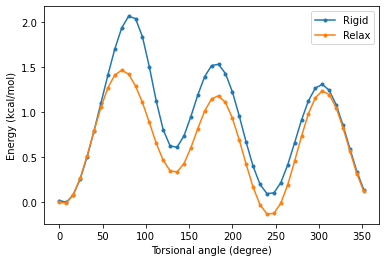

In [19]:
fig, ax = plt.subplots(1, 1)
plot_curve(x=angles1, y=rigid_E,
           relative_x=0, periodic_x=360, relative_y='min',
           ax=ax,
           xlabel='Torsional angle (degree)',
           ylabel='Energy (kcal/mol)')
plot_curve(x=angles2, y=relax_E,
           relative_x=0, periodic_x=360, relative_y=0,
           ax=ax,
           xlabel='Torsional angle (degree)',
           ylabel='Energy (kcal/mol)')
ax.legend(['Rigid', 'Relax'])
